# Data Load

In [1]:
import pandas as pd
RawData = pd.read_csv("FundingProject.csv")
RawData.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1015685046,Organic Tattoo remains 10 days (Self use & cus...,Accessories,Fashion,CAD,1/1/2016,6000,12/7/2015 18:21,100.0,failed,2,CA,74.84,70.89,4253.51
1,1019043170,Handcrafted leather wallet | key holder | card...,Accessories,Fashion,EUR,1/1/2016,2000,12/11/2015 10:52,2102.0,successful,48,BE,2314.01,2282.97,2172.19
2,1036288991,The Liaisons: a new twist on the old standards,Jazz,Music,USD,1/1/2016,5000,11/9/2015 20:12,5630.0,successful,116,US,5630.00,5630.00,5000.00


In [2]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 15 columns):
ID                  110815 non-null int64
name                110814 non-null object
category            110815 non-null object
main_category       110815 non-null object
currency            110815 non-null object
deadline            110815 non-null object
goal                110815 non-null int64
launched            110815 non-null object
pledged             110815 non-null float64
state               110815 non-null object
backers             110815 non-null int64
country             110815 non-null object
usd pledged         109999 non-null float64
usd_pledged_real    110815 non-null float64
usd_goal_real       110815 non-null float64
dtypes: float64(4), int64(3), object(8)
memory usage: 12.7+ MB


# Process Data

In [3]:
import pandas as pd
ProcessedData = pd.DataFrame()

### Project status 

In [4]:
RawData["state"].describe()

count     110815
unique         6
top       failed
freq       58155
Name: state, dtype: object

In [5]:
RawData["state"].value_counts()

failed        58155
successful    38172
canceled      13178
suspended       707
undefined       596
live              7
Name: state, dtype: int64

In [6]:
# # Remap status labels to numerical values, bias starting from 2 for failures, scale to range of 1
# # At the same time, drop rows with unrelated state values or values which cannot be processed
# ProcessedData["Status"] = RawData.loc[RawData["state"].isin(["failed", "successful", "canceled", "suspended"]), "state"].map({
# #    "canceled" : 2,
#     "failed" : 2,
# #    "suspended" : 2,
#     "successful": 3,
# })

In [7]:
ProcessedData["Status"] = (RawData["pledged"] > RawData["goal"]).astype("uint8")

In [8]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 1 columns):
Status    110815 non-null uint8
dtypes: uint8(1)
memory usage: 108.3 KB


In [9]:
ProcessedData["Status"].value_counts()

0    72983
1    37832
Name: Status, dtype: int64

### Year, Month, Day, Day of Week

In [10]:
from datetime import datetime

In [11]:
LaunchDates = RawData["launched"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))

In [12]:
EndDates = RawData["deadline"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

In [13]:
ProcessedData["YearLaunched"] = LaunchDates.apply(lambda x: x.year).astype("uint16")

In [14]:
ProcessedData["YearLaunched"].describe()

count    110815.000000
mean       2016.401327
std           0.568251
min        2015.000000
25%        2016.000000
50%        2016.000000
75%        2017.000000
max        2017.000000
Name: YearLaunched, dtype: float64

In [15]:
ProcessedData["MonthLaunched"] = LaunchDates.apply(lambda x: x.month).astype("uint8")

In [16]:
ProcessedData["DayLaunched"] = LaunchDates.apply(lambda x: x.day).astype("uint8")

In [17]:
ProcessedData["DayOfWeekLaunched"] = LaunchDates.apply(lambda x: x.weekday()).replace(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]).astype("category")

In [18]:
ProcessedData["DayOfWeekLaunched"].value_counts()

Tue    23704
Wed    19257
Mon    18988
Thu    16789
Fri    15839
Sat     9222
Sun     7016
Name: DayOfWeekLaunched, dtype: int64

In [19]:
LaunchDates.head()

0   2015-12-07 18:21:00
1   2015-12-11 10:52:00
2   2015-11-09 20:12:00
3   2015-11-24 02:08:00
4   2015-11-17 12:30:00
Name: launched, dtype: datetime64[ns]

In [20]:
ProcessedData.head()

,Status,YearLaunched,MonthLaunched,DayLaunched,DayOfWeekLaunched
0,0,2015,12,7,Mon
1,1,2015,12,11,Fri
2,1,2015,11,9,Mon
3,0,2015,11,24,Tue
4,0,2015,11,17,Tue


### Campaign length (time)

In [21]:
from datetime import datetime
ProcessedData["Duration(Days)"] = (EndDates - LaunchDates).apply(lambda x: x.days + 1).astype("uint8")

In [22]:
ProcessedData["Duration(Days)"].describe()

count    110815.000000
mean         33.157849
std          11.640541
min           1.000000
25%          30.000000
50%          30.000000
75%          35.000000
max          90.000000
Name: Duration(Days), dtype: float64

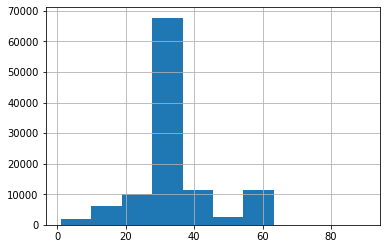

In [23]:
ProcessedData["Duration(Days)"].hist()

### Category and type

In [24]:
ProcessedData["Category"] = RawData["main_category"].astype("category")

In [25]:
ProcessedData["Subcategory"] = RawData["category"].astype("category")

In [26]:
ProcessedData["OverallCategory"] = (RawData["main_category"] + RawData["category"]).astype("category")

### Funding Goal
Use USD for consistency

In [27]:
RawData["usd_goal_real"].describe()

count    1.108150e+05
mean     5.388820e+04
std      1.271062e+06
min      4.900000e-01
25%      2.000000e+03
50%      6.214070e+03
75%      2.000000e+04
max      1.073699e+08
Name: usd_goal_real, dtype: float64

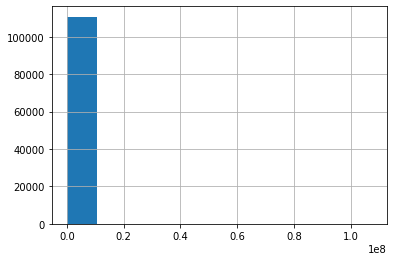

In [28]:
RawData["usd_goal_real"].hist()

In [29]:
import numpy as np
ProcessedData["log(FundingGoal)"] = RawData["usd_goal_real"].apply(np.log)

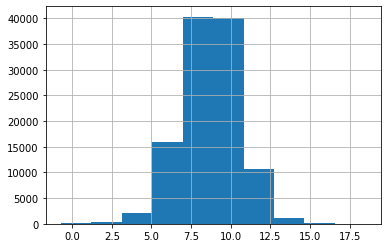

In [30]:
ProcessedData["log(FundingGoal)"].hist()

### Countries

In [31]:
RawData["country"].value_counts()

US      71905
GB      11991
CA       5555
AU       3181
DE       2865
IT       2195
FR       2084
ES       1741
MX       1633
NL       1124
SE        982
N,0"      816
CH        611
NZ        607
DK        597
HK        577
SG        523
IE        466
BE        465
AT        443
NO        378
LU         47
JP         29
Name: country, dtype: int64

In [32]:
ProcessedData["Country"] = RawData["country"].replace("N,0\"", "NO").map(pd.read_csv("CountryCodes.csv").set_index("Code")["Name"].to_dict()).astype("category")

In [33]:
ProcessedData["Country"].value_counts()

United States     71905
United Kingdom    11991
Canada             5555
Australia          3181
Germany            2865
Italy              2195
France             2084
Spain              1741
Mexico             1633
Norway             1194
Netherlands        1124
Sweden              982
Switzerland         611
New Zealand         607
Denmark             597
Hong Kong           577
Singapore           523
Ireland             466
Belgium             465
Austria             443
Luxembourg           47
Japan                29
Name: Country, dtype: int64

In [34]:
# This kinda begs the question because the pledged amount determines success
#ProcessedData["FundingRate(USD/Day)"] = RawData["usd_pledged_real"] / ProcessedData["Duration(Days)"]

# Drop extra data

In [35]:
def ShowCorrelationHeatmap(DataFrame, FigureSize = (10, 10)):
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    plt.close()
    axes = plt.figure(figsize = FigureSize).add_subplot(111)
    sns.heatmap(pd.DataFrame(DataFrame.corr(method = "spearman")["Status"]).T, annot = True)

    # Fix for cutoff top and bottom (Apparently bug with matplotlib version 3.1.1)
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)

    plt.show()

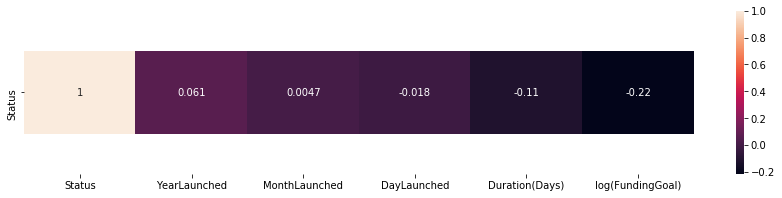

In [36]:
ShowCorrelationHeatmap(ProcessedData, FigureSize = (15, 3))

In [37]:
#ProcessedData.drop(["Subcategory", "OverallCategory", "Country"], axis = 1, inplace = True)

# Modeling

In [38]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 11 columns):
Status               110815 non-null uint8
YearLaunched         110815 non-null uint16
MonthLaunched        110815 non-null uint8
DayLaunched          110815 non-null uint8
DayOfWeekLaunched    110815 non-null category
Duration(Days)       110815 non-null uint8
Category             110815 non-null category
Subcategory          110815 non-null category
OverallCategory      110815 non-null category
log(FundingGoal)     110815 non-null float64
Country              110815 non-null category
dtypes: category(5), float64(1), uint16(1), uint8(4)
memory usage: 2.2 MB


In [39]:
ProcessedData.dropna(inplace = True)

In [40]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Data columns (total 11 columns):
Status               110815 non-null uint8
YearLaunched         110815 non-null uint16
MonthLaunched        110815 non-null uint8
DayLaunched          110815 non-null uint8
DayOfWeekLaunched    110815 non-null category
Duration(Days)       110815 non-null uint8
Category             110815 non-null category
Subcategory          110815 non-null category
OverallCategory      110815 non-null category
log(FundingGoal)     110815 non-null float64
Country              110815 non-null category
dtypes: category(5), float64(1), uint16(1), uint8(4)
memory usage: 3.1 MB


In [41]:
ProcessedData["Status"].value_counts()

0    72983
1    37832
Name: Status, dtype: int64

In [42]:
# Show dupes and null counts per column
for column in ProcessedData.columns.to_list():
    print(column, ":", ProcessedData[column].duplicated().sum(), " - " , ProcessedData[column].isnull().sum())

Status : 110813  -  0
YearLaunched : 110812  -  0
MonthLaunched : 110803  -  0
DayLaunched : 110784  -  0
DayOfWeekLaunched : 110808  -  0
Duration(Days) : 110750  -  0
Category : 110800  -  0
Subcategory : 110656  -  0
OverallCategory : 110645  -  0
log(FundingGoal) : 86654  -  0
Country : 110793  -  0


## Generate baseline model without using title field

In [43]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

def AssessClassifierModels(TrainingDataColumns, TrainingDataResults, TestingDataColumns, TestingDataResults, Models_List):
    from datetime import datetime
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    results_list = pd.DataFrame()
    
    for modelClass in Models_List:
        startTime = datetime.now()
        print("Starting " + str(modelClass.__name__) + " at " + str(startTime))
        
        model = modelClass()
        model.fit(TrainingDataColumns, TrainingDataResults)
        predictions = model.predict(TestingDataColumns)
        
        endTime = datetime.now()
        positiveValue = TestingDataResults.max()

        results_list = results_list.append({
            "Name" : modelClass.__name__,
            "F1": f1_score(TestingDataResults, predictions, pos_label = positiveValue),
            "Accuracy": accuracy_score(TestingDataResults, predictions),
            "Precision": precision_score(TestingDataResults, predictions, pos_label = positiveValue),
            "Recall" : recall_score(TestingDataResults, predictions, pos_label = positiveValue),
            "RunTime" : str(endTime - startTime),
            "ConfusionMatrix" : confusion_matrix(TestingDataResults, predictions),
            "ModelObject": model,
        }, ignore_index = True)
    
    results_list.sort_values("F1", ascending = False, inplace = True)
    
    return results_list

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

def AssessRegressorModels(TrainingDataColumns, TrainingDataResults, TestingDataColumns, TestingDataResults, Models_List):
    from datetime import datetime
    import pandas as pd
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    
    results_list = pd.DataFrame()
    
    for modelClass in Models_List:
        model = modelClass()
        startTime = datetime.now()
        print("Starting " + str(modelClass.__name__) + " at " + str(startTime))
        
        model.fit(TrainingDataColumns, TrainingDataResults)
        predictions = model.predict(TestingDataColumns)
        
        endTime = datetime.now()

        results_list = results_list.append(pd.DataFrame(data = {
            "Name" : modelClass.__name__,
            "R2Score" : r2_score(TestingDataResults, predictions),
            "RMSE" : mean_squared_error(TestingDataResults, predictions)**0.5,
            "MAE" : mean_absolute_error(TestingDataResults, predictions),
            "RunTime" : str(endTime - startTime),
            "ModelObject" : [model],
        }), ignore_index = True)
    
    results_list.sort_values("R2Score", inplace = True, ascending = False)
    
    return results_list

In [45]:
print(datetime.now())

2020-02-08 07:07:42.732055


In [46]:
TrainingData = pd.get_dummies(ProcessedData, drop_first = True)

In [47]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Columns: 374 entries, Status to Country_United States
dtypes: float64(1), uint16(1), uint8(372)
memory usage: 41.2 MB


In [48]:
print(datetime.now())

2020-02-08 07:07:42.971892


In [49]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(TrainingData.drop("Status", axis = 1), TrainingData["Status"], test_size = 0.2, random_state = 13)

In [50]:
print(datetime.now())

2020-02-08 07:07:43.174009


In [51]:
RegressorResults_List = AssessRegressorModels(Train_X, Train_Y, Test_X, Test_Y, [LinearRegression, Ridge, Lasso, ExtraTreeRegressor, ElasticNet, GradientBoostingRegressor, XGBRegressor])

Starting LinearRegression at 2020-02-08 07:07:43.208170
Starting Ridge at 2020-02-08 07:07:44.747282
Starting Lasso at 2020-02-08 07:07:45.421369
Starting ExtraTreeRegressor at 2020-02-08 07:07:46.119297
Starting ElasticNet at 2020-02-08 07:07:51.814388
Starting GradientBoostingRegressor at 2020-02-08 07:07:52.473261
Starting XGBRegressor at 2020-02-08 07:08:56.310602


C:\Users\root\.conda\envs\DataScience\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:08:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(RegressorResults_List)

,Name,R2Score,RMSE,MAE,RunTime,ModelObject
5,GradientBoostingRegressor,0.153409,0.435883,0.392403,0:01:03.832422,([DecisionTreeRegressor(ccp_alpha=0....
6,XGBRegressor,0.153027,0.435982,0.392314,0:00:41.302545,"XGBRegressor(base_score=0.5, booster..."
1,Ridge,0.144980,0.438048,0.386151,0:00:00.668470,"Ridge(alpha=1.0, copy_X=True, fit_in..."
0,LinearRegression,0.144954,0.438055,0.386135,0:00:01.534200,"LinearRegression(copy_X=True, fit_in..."
4,ElasticNet,0.012856,0.470678,0.445817,0:00:00.654733,"ElasticNet(alpha=1.0, copy_X=True, f..."
2,Lasso,-0.000012,0.473736,0.449376,0:00:00.693719,"Lasso(alpha=1.0, copy_X=True, fit_in..."
3,ExtraTreeRegressor,-0.601758,0.599559,0.360105,0:00:05.689572,"ExtraTreeRegressor(ccp_alpha=0.0, cr..."


In [53]:
print(datetime.now())

2020-02-08 07:09:37.704789


In [54]:
with pd.option_context("display.max_columns", None, "display.max_rows", 40, "display.max_colwidth", 80):
    display(pd.DataFrame(data = {
        "Names" : TrainingData.drop("Status", axis = 1).columns.to_list(),
        "Weight": (RegressorResults_List.loc[RegressorResults_List["Name"] == "XGBRegressor", "ModelObject"]).iloc[0].feature_importances_,
    }).sort_values(by="Weight", ascending = False))

,Names,Weight
11,Category_Comics,0.061704
160,Subcategory_Tabletop Games,0.058552
32,Subcategory_Apps,0.052095
15,Category_Fashion,0.034679
4,log(FundingGoal),0.033778
...,...,...
162,Subcategory_Technology,0.000000
161,Subcategory_Taxidermy,0.000000
159,Subcategory_Stationery,0.000000
157,Subcategory_Space Exploration,0.000000


In [55]:
ClassifierResults_List = AssessClassifierModels(Train_X, Train_Y, Test_X, Test_Y, [GaussianNB, BernoulliNB, RandomForestClassifier, DecisionTreeClassifier, ExtraTreesClassifier, GradientBoostingClassifier, XGBClassifier])

Starting GaussianNB at 2020-02-08 07:09:37.793589
Starting BernoulliNB at 2020-02-08 07:09:38.838588
Starting RandomForestClassifier at 2020-02-08 07:09:39.611502
Starting DecisionTreeClassifier at 2020-02-08 07:10:33.600231
Starting ExtraTreesClassifier at 2020-02-08 07:10:39.522601
Starting GradientBoostingClassifier at 2020-02-08 07:11:57.270613
Starting XGBClassifier at 2020-02-08 07:12:53.531447


In [56]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(ClassifierResults_List)

,Accuracy,ConfusionMatrix,F1,ModelObject,Name,Precision,Recall,RunTime
0,0.601588,"[[7698, 6928], [1902, 5635]]",0.560697,"GaussianNB(priors=None, var_smoothin...",GaussianNB,0.448539,0.747645,0:00:01.004505
1,0.669043,"[[11055, 3571], [3764, 3773]]",0.507090,"BernoulliNB(alpha=1.0, binarize=0.0,...",BernoulliNB,0.513753,0.500597,0:00:00.718217
2,0.698236,"[[12416, 2210], [4478, 3059]]",0.477745,(DecisionTreeClassifier(ccp_alpha=0....,RandomForestClassifier,0.580566,0.405864,0:00:53.955059
4,0.680368,"[[12000, 2626], [4458, 3079]]",0.465035,"(ExtraTreeClassifier(ccp_alpha=0.0, ...",ExtraTreesClassifier,0.539702,0.408518,0:01:17.709644
3,0.635428,"[[10595, 4031], [4049, 3488]]",0.463337,DecisionTreeClassifier(ccp_alpha=0.0...,DecisionTreeClassifier,0.463891,0.462784,0:00:05.889402
5,0.706493,"[[13497, 1129], [5376, 2161]]",0.399187,([DecisionTreeRegressor(ccp_alpha=0....,GradientBoostingClassifier,0.656839,0.286719,0:00:56.226715
6,0.702883,"[[13589, 1037], [5548, 1989]]",0.376598,"XGBClassifier(base_score=0.5, booste...",XGBClassifier,0.657303,0.263898,0:00:41.101009


In [57]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 80):
    display(pd.DataFrame(data = {
        "Names" : TrainingData.drop("Status", axis = 1).columns.to_list(),
        "Weight": (ClassifierResults_List.loc[ClassifierResults_List["Name"] == "XGBClassifier", "ModelObject"]).iloc[0].feature_importances_,
    }).sort_values(by="Weight", ascending = False).head(20))

,Names,Weight
23,Category_Technology,0.092903
11,Category_Comics,0.051321
32,Subcategory_Apps,0.046834
175,Subcategory_Web,0.041901
160,Subcategory_Tabletop Games,0.041757
3,Duration(Days),0.034910
20,Category_Music,0.034021
4,log(FundingGoal),0.030720
15,Category_Fashion,0.028858
92,Subcategory_Hip-Hop,0.026056


## Generate model using title field

### Tokenize words in title

In [58]:
def GetWords_List(TextString):
    import re
    print(TextString)
    wordCheck = re.compile(r"[^a-zA-Z0-9]+")
    return [word for word in wordCheck.split(TextString) if (len(word) > 1)]

In [59]:
import re
wordCheck = re.compile(r"[^a-zA-Z0-9]+")
ProcessedData["Name_WordList"] = RawData["name"].fillna("").apply(lambda x: [word for word in wordCheck.split(x) if (len(word) > 1)])

In [60]:
ProcessedData["Name_WordList"].head()

0    [Organic, Tattoo, remains, 10, days, Self, use...
1    [Handcrafted, leather, wallet, key, holder, ca...
2    [The, Liaisons, new, twist, on, the, old, stan...
3            [The, Many, Encounters, of, Bosley, Bear]
4               [Swift, Co, Innovative, Men, Footwear]
Name: Name_WordList, dtype: object

### Calculate readability / complexity / length of text
How likely title is glossed over

Flesch Kincaid?

In [61]:
#!pip install textstat
from textstat import flesch_reading_ease as ReadabilityScore

In [62]:
RawData["name"]

0         Organic Tattoo remains 10 days (Self use & cus...
1         Handcrafted leather wallet | key holder | card...
2           The Liaisons:  a new twist on the old standards
3                        The Many Encounters of Bosley Bear
4                    Swift & Co | Innovative Men's Footwear
                                ...                        
110810    Project ChArma presents Full Circle at Dance P...
110811                              Haboob Wind - The Movie
110812                                            Honey Pot
110813    LOL Mugs with daily laugh and inspirational me...
110814                  Tapagotchi - Mobile Virtual Pet RPG
Name: name, Length: 110815, dtype: object

In [63]:
ProcessedData["Name_WordCount"] = ProcessedData["Name_WordList"].apply(len).astype("uint8")

In [64]:
ProcessedData["Name_WordCount"].describe()

count    110815.000000
mean          5.275775
std           2.478234
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          14.000000
Name: Name_WordCount, dtype: float64

In [65]:
ProcessedData["Name_Readability"] = RawData["name"].fillna("").apply(ReadabilityScore)

In [66]:
ProcessedData["Name_Readability"].describe()

count    110815.000000
mean         57.993754
std          43.448520
min        -978.590000
25%          35.610000
50%          63.360000
75%          87.720000
max         206.840000
Name: Name_Readability, dtype: float64

In [67]:
with pd.option_context("display.max_colwidth", 100):
    display(RawData[ProcessedData["Name_Readability"] < -500]["name"])

2258      A SAFER                                  USB Charger-Adaptor
5445       CHALKUP,handchalk,workoutchalk,gym,fitnessgear,bodybuilding
16669                                          PoliticalRevolution.net
19076                                         #DigitalRealistStoryMode
80861                              Vestuario//cosplay//caracterización
87284                   OverTymeMusicRadio/FutureCommunicationsNetwork
93042                              D.A.H.A(demon.angel.hybrid.academy)
105543                       Mobile.Survival.Horror.Game.by.NaticaTech
Name: name, dtype: object

### Calculate sentiment of each title
How positive or optimistic titles feel

In [68]:
def GetTextSentiment(TextString):
    from textblob import TextBlob
    return TextBlob(TextString).sentiment.polarity    

In [69]:
ProcessedData["Name_SentimentValue"] = RawData["name"].fillna("").apply(GetTextSentiment)

In [70]:
ProcessedData["Name_SentimentValue"].describe()

count    110815.000000
mean          0.045917
std           0.208649
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Name_SentimentValue, dtype: float64

### Calculate average TD-IDF of words in each title
How often are similar campaigns started.
Basically reader fatigue.

In [71]:
def FilterForKeyWords(TextString):
    import nltk
    import re
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus.reader import wordnet
    from nltk.util import ngrams

    LemmatizerEngine = WordNetLemmatizer()
    removeWords_List = list(set([
        # Prepositions
        "of", "with", "without", "at", "from", "into", "during", "including", "until", "against", "through", "throughput",
        "towards", "to", "upon", "concerning", "in", "out", "for", "on", "below", "by", "over", "under", "despite",
        "before", "after", "between", "since", "among", "along", "following", "across", "behind", "beyond", "except",
        "but", "up", "down", "aboard", "amid", "as", "behind", "considering", "during", "inside", "minus", "off", "per",
        "versus", "via",
    ]))

    alphaCheck = re.compile(r"^[a-z]+$")

    POSTagToLemmaTag_Dict = {
        "J" : wordnet.ADJ,
        "N" : wordnet.NOUN,
        "V" : wordnet.VERB,
        "R" : wordnet.ADV,
    }

    return str([LemmatizerEngine.lemmatize(word, POSTagToLemmaTag_Dict[pos[0]]) for (word, pos) in nltk.pos_tag(nltk.word_tokenize(TextString.lower()))
            if (
                (len(word) > 1) # 
                & (alphaCheck.match(word) != None)
                & (word not in removeWords_List)
                & (pos[0] in [
                    "J",#"JJ", "JJR", "JJS", # Adjectives
                    "N",#"NN", "NNS", "NNP", "NNPS", # Nouns
                    "R",#"RB", "RBR", "RBS", # Adverbs
                    "V",#"VB", "VBD", "VBG", "VBN", "VBP", "VBZ", #Verbs
                    ])
               )
               ])

def GetPrincipalWordCounts(DataFrame, TextColumnName):
    from sklearn.feature_extraction.text import CountVectorizer
    from datetime import datetime # For debugging performance data

    Vectorizer = CountVectorizer(lowercase = False, strip_accents = "ascii", preprocessor = FilterForKeyWords,
                                 min_df = 0.005, ngram_range = (1, 3),
                                )
    startTime = datetime.now() # For debugging performance data

    # Filter out unwanted words in each row, then create count columns for remaining words 
    WordCounts = pd.DataFrame(
        Vectorizer.fit_transform(DataFrame[TextColumnName]).toarray(), 
        columns=Vectorizer.get_feature_names(), 
        #dtype = "uint8",
    )

    return WordCounts

def GetTFIDF(TextMatrix):
    return

In [72]:
Name_WordCountsData = GetPrincipalWordCounts(pd.DataFrame(RawData["name"].fillna("")), "name").add_prefix("Count(").add_suffix(")")
display(Name_WordCountsData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 66 columns):
Count(adventure)      110815 non-null int64
Count(album)          110815 non-null int64
Count(app)            110815 non-null int64
Count(art)            110815 non-null int64
Count(bag)            110815 non-null int64
Count(be)             110815 non-null int64
Count(best)           110815 non-null int64
Count(board)          110815 non-null int64
Count(book)           110815 non-null int64
Count(cancel)         110815 non-null int64
Count(card)           110815 non-null int64
Count(card game)      110815 non-null int64
Count(child)          110815 non-null int64
Count(coffee)         110815 non-null int64
Count(collection)     110815 non-null int64
Count(comic)          110815 non-null int64
Count(day)            110815 non-null int64
Count(debut)          110815 non-null int64
Count(design)         110815 non-null int64
Count(documentary)    110815 non-null int64
Count(dre

None

In [73]:
Name_WordCountsData.describe()

,Count(adventure),Count(album),Count(app),Count(art),Count(bag),Count(be),Count(best),Count(board),Count(book),Count(cancel),...,Count(story),Count(studio),Count(system),Count(time),Count(travel),Count(ultimate),Count(video),Count(war),Count(watch),Count(world)
count,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,...,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000
mean,0.008447,0.025331,0.011442,0.022298,0.005839,0.021134,0.005568,0.006100,0.030564,0.029103,...,0.009917,0.008158,0.005821,0.006533,0.005496,0.005117,0.008699,0.005487,0.009782,0.022533
std,0.091910,0.157529,0.106864,0.151514,0.080338,0.151651,0.075134,0.079016,0.174737,0.168684,...,0.100179,0.090651,0.076543,0.082666,0.075976,0.071600,0.093734,0.075320,0.105415,0.149319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,4.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [74]:
Name_WordCountsData.max().sort_values(ascending = False)

Count(be)             6
Count(card)           4
Count(art)            4
Count(good)           3
Count(help)           3
                     ..
Count(adventure)      2
Count(debut)          1
Count(card game)      1
Count(documentary)    1
Count(edition)        1
Length: 66, dtype: int64

In [75]:
# Common words for failures
# ProcessedData[ProcessedData["Status"] == 0]

In [76]:
# Common words for successes
# ProcessedData[ProcessedData["Status"] == 1]

In [77]:
# Common words by category

In [78]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Data columns (total 15 columns):
Status                 110815 non-null uint8
YearLaunched           110815 non-null uint16
MonthLaunched          110815 non-null uint8
DayLaunched            110815 non-null uint8
DayOfWeekLaunched      110815 non-null category
Duration(Days)         110815 non-null uint8
Category               110815 non-null category
Subcategory            110815 non-null category
OverallCategory        110815 non-null category
log(FundingGoal)       110815 non-null float64
Country                110815 non-null category
Name_WordList          110815 non-null object
Name_WordCount         110815 non-null uint8
Name_Readability       110815 non-null float64
Name_SentimentValue    110815 non-null float64
dtypes: category(5), float64(3), object(1), uint16(1), uint8(5)
memory usage: 5.7+ MB


In [79]:
ProcessedData.describe()

,Status,YearLaunched,MonthLaunched,DayLaunched,Duration(Days),log(FundingGoal),Name_WordCount,Name_Readability,Name_SentimentValue
count,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000,110815.000000
mean,0.341398,2016.401327,6.303822,15.254812,33.157849,8.703961,5.275775,57.993754,0.045917
std,0.474181,0.568251,3.420491,8.896393,11.640541,1.755499,2.478234,43.448520,0.208649
min,0.000000,2015.000000,1.000000,1.000000,1.000000,-0.713350,0.000000,-978.590000,-1.000000
25%,0.000000,2016.000000,3.000000,7.000000,30.000000,7.600902,3.000000,35.610000,0.000000
50%,0.000000,2016.000000,6.000000,15.000000,30.000000,8.734571,5.000000,63.360000,0.000000
75%,1.000000,2017.000000,9.000000,23.000000,35.000000,9.903488,7.000000,87.720000,0.000000
max,1.000000,2017.000000,12.000000,31.000000,90.000000,18.491790,14.000000,206.840000,1.000000


## Modeling with name included

In [80]:
TrainingData = pd.concat([
    pd.get_dummies(ProcessedData.drop(["Subcategory", "Country", "OverallCategory", "Name_WordList"], axis = 1), drop_first = True),
    Name_WordCountsData
], axis = 1)

In [81]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Data columns (total 95 columns):
Status                   110815 non-null uint8
YearLaunched             110815 non-null uint16
MonthLaunched            110815 non-null uint8
DayLaunched              110815 non-null uint8
Duration(Days)           110815 non-null uint8
log(FundingGoal)         110815 non-null float64
Name_WordCount           110815 non-null uint8
Name_Readability         110815 non-null float64
Name_SentimentValue      110815 non-null float64
DayOfWeekLaunched_Mon    110815 non-null uint8
DayOfWeekLaunched_Sat    110815 non-null uint8
DayOfWeekLaunched_Sun    110815 non-null uint8
DayOfWeekLaunched_Thu    110815 non-null uint8
DayOfWeekLaunched_Tue    110815 non-null uint8
DayOfWeekLaunched_Wed    110815 non-null uint8
Category_Comics          110815 non-null uint8
Category_Crafts          110815 non-null uint8
Category_Dance           110815 non-null uint8
Category_Design          110815 non-

In [82]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(TrainingData.drop("Status", axis = 1), TrainingData["Status"], test_size = 0.2, random_state = 13)

In [83]:
RegressorResults_List = AssessRegressorModels(Train_X, Train_Y, Test_X, Test_Y, [LinearRegression, Ridge, Lasso, ExtraTreeRegressor, ElasticNet, GradientBoostingRegressor, XGBRegressor])

Starting LinearRegression at 2020-02-08 07:15:33.457077
Starting Ridge at 2020-02-08 07:15:33.713531
Starting Lasso at 2020-02-08 07:15:33.863426
Starting ExtraTreeRegressor at 2020-02-08 07:15:34.053106
Starting ElasticNet at 2020-02-08 07:15:35.837594
Starting GradientBoostingRegressor at 2020-02-08 07:15:36.019886
Starting XGBRegressor at 2020-02-08 07:15:55.559918
[07:15:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\root\.conda\envs\DataScience\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [84]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(RegressorResults_List.drop("ModelObject", axis = 1))

,Name,R2Score,RMSE,MAE,RunTime
5,GradientBoostingRegressor,0.161335,0.433838,0.389372,0:00:19.537215
6,XGBRegressor,0.160067,0.434166,0.390029,0:00:11.570977
1,Ridge,0.135582,0.440449,0.392647,0:00:00.145635
0,LinearRegression,0.135580,0.440449,0.392638,0:00:00.252902
4,ElasticNet,0.013197,0.470596,0.445726,0:00:00.175227
2,Lasso,-0.000012,0.473736,0.449376,0:00:00.185417
3,ExtraTreeRegressor,-0.681433,0.614290,0.377363,0:00:01.781661


In [85]:
ClassifierResults_List = AssessClassifierModels(Train_X, Train_Y, Test_X, Test_Y, [GaussianNB, BernoulliNB, RandomForestClassifier, DecisionTreeClassifier, ExtraTreesClassifier, GradientBoostingClassifier, XGBClassifier])

Starting GaussianNB at 2020-02-08 07:16:07.206497
Starting BernoulliNB at 2020-02-08 07:16:07.523035
Starting RandomForestClassifier at 2020-02-08 07:16:07.775984
Starting DecisionTreeClassifier at 2020-02-08 07:16:28.556897
Starting ExtraTreesClassifier at 2020-02-08 07:16:30.244127
Starting GradientBoostingClassifier at 2020-02-08 07:17:01.167002
Starting XGBClassifier at 2020-02-08 07:17:20.786008


In [86]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(ClassifierResults_List.drop("ModelObject", axis = 1))

,Accuracy,ConfusionMatrix,F1,Name,Precision,Recall,RunTime
2,0.706222,"[[12818, 1808], [4703, 2834]]",0.465391,RandomForestClassifier,0.610513,0.376012,0:00:20.747182
3,0.628841,"[[10399, 4227], [3999, 3538]]",0.462423,DecisionTreeClassifier,0.455634,0.469418,0:00:01.652797
4,0.696972,"[[12605, 2021], [4695, 2842]]",0.458387,ExtraTreesClassifier,0.584413,0.377073,0:00:30.884928
0,0.663764,"[[11720, 2906], [4546, 2991]]",0.445288,GaussianNB,0.507207,0.396842,0:00:00.273438
5,0.705771,"[[13326, 1300], [5221, 2316]]",0.415314,GradientBoostingClassifier,0.640487,0.307284,0:00:19.584634
6,0.705229,"[[13419, 1207], [5326, 2211]]",0.403651,XGBClassifier,0.646870,0.293353,0:00:12.129455
1,0.679601,"[[13168, 1458], [5643, 1894]]",0.347874,BernoulliNB,0.565036,0.251294,0:00:00.198544
